## 데이터 전처리


### 문제 정의


층간소음 데이터를 생성하기 위해 달리기, 망치 두들기기, 등의 행동을 수행하였다. 이때 각 행동과 행동 사이의 간격은 모델의 입력 벡터 크기인 1.28초보다 클 가능성이 있으며 간격이 불규칙적이여서 단순히 전체 데이터를 1.28초로 나누는 것은 적절하지 않다.

이에 따라 단순히 1초 단위로 데이터를 잘라 전처리를 수행하였던 기존 방법은 한계점을 지니며, 모델의 성능 또한 높지 않았다.

따라서 단순히 데이터를 분할하는 것이 아닌 임계값 이상의 편차를 가지는 데이터 추출함을 통해 데이터를 전처리하고자 한다.


In [1]:
# Load packages
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os
import sys

In [2]:
# Set Path
data_dir = '/Users/jaewone/Downloads/sensor_data_교수님'
white_file = '/Users/jaewone/Downloads/floor_noise/sensor_data/dataset/white_data.txt'
file_list = [os.path.join(data_dir, file) for file in os.listdir(data_dir)]
prefix = 'sensor_data_quite'
os.listdir(data_dir)

['sensor_data_quite_run.txt',
 'sensor_data_quite_rolling_hammer.txt',
 'sensor_data_quite_random_walk.txt',
 'sensor_data_quite_walk.txt',
 'sensor_data_quite_hammer.txt',
 'sensor_data_quite_table.txt']

### 데이터 확인


먼제 데이터를 가져와 확인해보자.


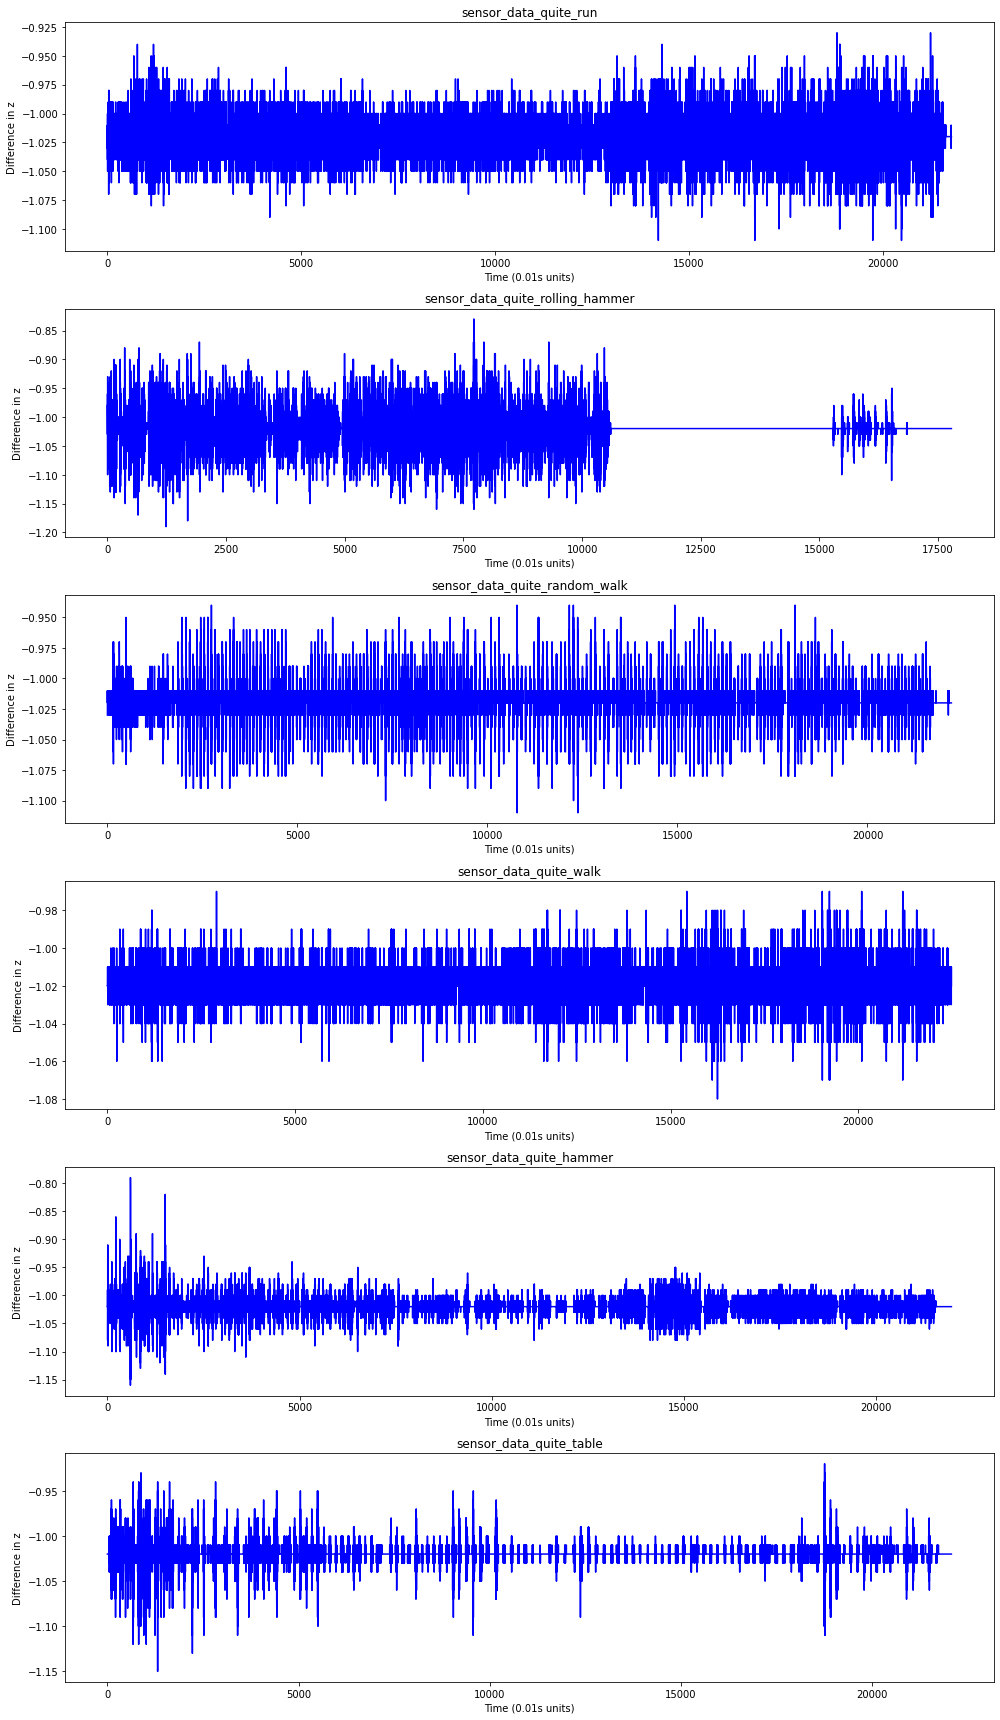

In [3]:
from typing import Callable, List, Optional

# 수행하고자 하는 데이터 전처리 함수


def diff(df: pd.DataFrame) -> pd.DataFrame:
    return

# 데이터 전처리 함수를 적용한 다음 파일에 따라 비교한다.


def compare_states(file_list: List[str],
                   data_trans_func: Optional[Callable] = None,
                   show_label: str = 'z',
                   start_index: int = 0,
                   end_index: int = -1):
    """
    이전 데이터 포인트와의 차이를 표시하는 그래프를 그립니다.

    file_list: List[str] - 표현하고자 하는 파일의 경로 리스트
    data_trans_func: Callable - 데이터 전처리 함수
    show_label: str - 표현하고자 하는 축을 선택합니다. x, y, z 중 하나를 선택할 수 있습니다.
    """
    assert show_label in ['x', 'y', 'z'], 'show_label must be one of x, y, z'

    len_file_list = len(file_list)
    plt.figure(figsize=(14, 4 * len_file_list))
    for i in range(len_file_list):
        data = pd.read_csv(file_list[i], header=None, names=[
                           'x', 'y', 'z']).loc[:, show_label]
        data = data.iloc[start_index:end_index]

        if (data_trans_func):
            data = data_trans_func(data)

        plt.subplot(len_file_list, 1, i + 1)
        plt.plot(data, label=show_label, color='b')
        plt.title(file_list[i].split('/')[-1].split('.')[0])
        plt.xlabel('Time (0.01s units)')
        plt.ylabel('Difference in z')
    plt.tight_layout()
    plt.show()


compare_states(file_list)

전체 데이터를 확인해보았을 때 rolling_hammer에서 약 50초간 빈 음성이 존재한다. 이는 화면이 잠시 꺼졌을 때, 측정이 중단되었기 때문이다.

이와 같이 수집된 층간소음 데이터의 모든 부분이 층간소음이라고 정의될 수 없다. 층간소음이 발생되었는 부분을 정확히 구분해야 한다.


### 데이터 전처리의 유효성 확인


이를 위하여 아래와 같은 아이디어를 낼 수 있다.

1. 현재 데이터포인터와 다음 데이터포이트 간의 차이의 절댓값을 구하여 편차를 구한다.

2. 추출하고자 하는 데이터 범위인 128(1.28초)를 하나의 window로 하여 옆으로 이동하며 해당하는 window가 층간소음 데이터인지 판단하고자 한다. 판단 기준은 해당 window가 편차 평균 이상의 값을 포함하고 있는지를 기준으로 한다.


위 아이디어를 검증하기 위하여 먼저 전체 행위에 대하여 편차를 구해 그래프를 그려보자.


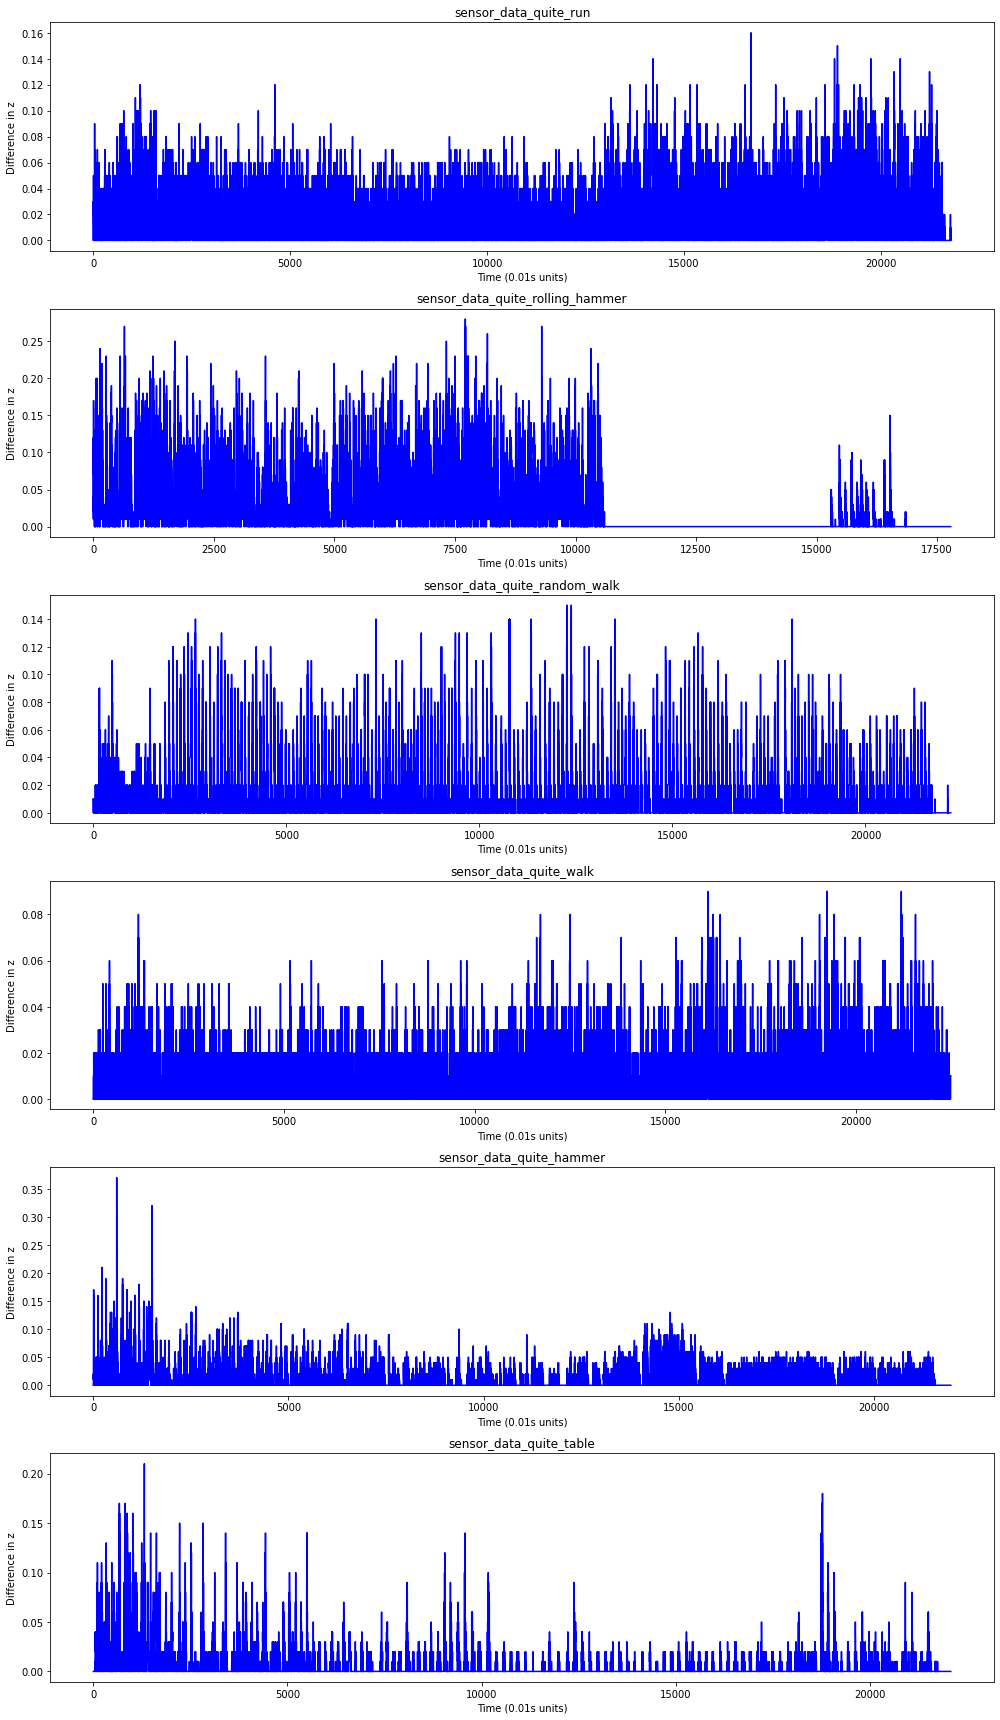

In [4]:
compare_states(file_list, lambda ser: ser.diff(
).iloc[1:].abs(), show_label='z')

각 행위에 따라 서로 다른 주기로 진동이 반복됨을 확인할 수 있다.

이번에는 층간소음이 없을 때의 데이터를 확인해보자.


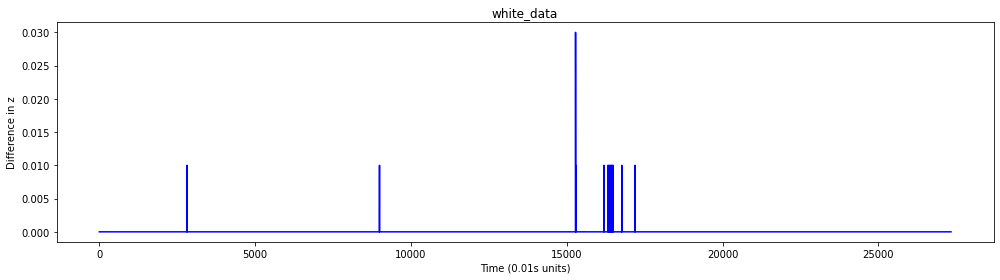

In [5]:
compare_states([white_file], lambda ser: ser.diff(
).iloc[1:].abs(), show_label='z')

이상치가 존재하기는 하나 전체적으로 보았을 때 편차가 0에 수렴하는 것을 확인할 수 있다.

이를 통해 편차가 크게 존재하는 부분은 층간소음이 발생한 부분이라고 추측할 수 있다.

이에 window 크기인 128의 절반 값인 64만큼 윈도우를 이동시키며 해당 window가 편차 평균 이상의 값을 포함하고 있는지를 확인해 볼 것이다.


먼저 드릴(rolling hammer) 행위에 대해서 추출된 노이즈 데이터를 확인해보자. 해당 데이터는 50초 가량 빈 데이터가 존재하는 것이 특징이다.

빈 데이터를 제외하고 층간 소음으로 판단되는 데이터만을 추출하는지 중점적으로 확인해볼 것이다.

아래 그래프는 노이즈로 판단되는 window 5개로 좌측은 원본 데이터이며 우측은 편차를 구한 데이터이다.


(182, 64, 3)


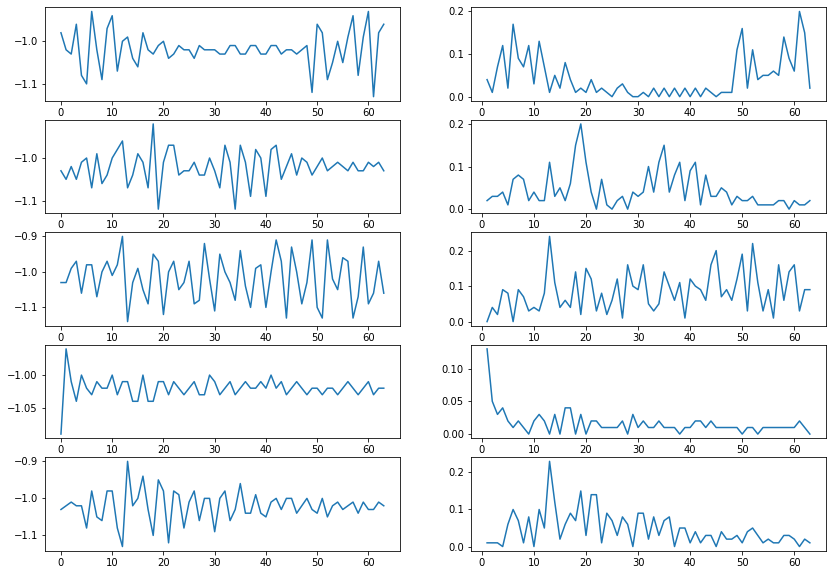

In [6]:
def find_interfloor_noise_data(file_path, window_size=64, threshold=None):
    df = pd.read_csv(file_path, header=None, names=['x', 'y', 'z'])

    delta_df = df.diff().iloc[1:].abs()

    if threshold is None:
        threshold = delta_df.iloc[:, 2].mean()

    noise_windows = []

    for start_index in range(0, len(delta_df) - window_size + 1, window_size):
        # Select the window
        window = delta_df.iloc[start_index:start_index + window_size, 2]

        if (window > threshold).any():
            noise_windows.append(
                df.iloc[start_index:start_index + window_size].values)

    noise_windows_array = np.array(noise_windows)

    return noise_windows_array


def show_interfloor_noise_data(noise_windows_data, render_graph_count=5):
    graph_count = render_graph_count if noise_windows_data.shape[
        0] > render_graph_count else noise_windows_data.shape[0]

    plt.subplots(graph_count, 2, figsize=(14, 2*graph_count))
    for i in range(graph_count):
        plt.subplot(graph_count, 2, i*2+1)
        plt.plot(noise_windows_data[i, :, 2])
        plt.subplot(graph_count, 2, i*2 + 2)
        plt.plot(pd.DataFrame(
            noise_windows_data[i]).diff().iloc[1:].abs().iloc[:, 2])
    plt.tight_layout()
    plt.show()


noise_windows_data = find_interfloor_noise_data(file_list[1])
print(noise_windows_data.shape)

show_interfloor_noise_data(noise_windows_data)

편차가 큰 부분에서 진동이 많이 발생함을 확인할 수 있으며 이는 층간소음이 발생한 부분임을 추측할 수 있다.

추출된 window를 모두 합쳐 하나의 그래프로 나타내어 50초 가량의 빈 데이터를 추출하지 않았는지 확인해보자.


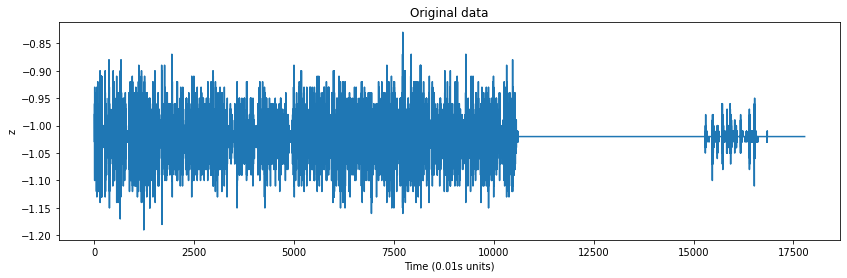

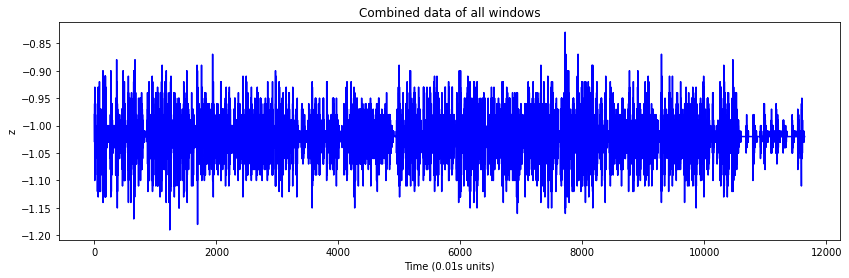

In [7]:
plt.figure(figsize=(14, 4))
plt.plot(pd.read_csv(file_list[1], header=None, names=[
         'x', 'y', 'z']).loc[:, 'z'], label='z')
plt.title('Original data')
plt.xlabel('Time (0.01s units)')
plt.ylabel('z')
plt.show()

combined_data = noise_windows_data.reshape(-1,
                                           noise_windows_data.shape[-1])[:, 2]

plt.figure(figsize=(14, 4))
plt.plot(combined_data, label='z', color='b')
plt.title('Combined data of all windows')
plt.xlabel('Time (0.01s units)')
plt.ylabel('z')
plt.show()

코볼트 색상의 데이터(Original data)에 존재하는 50초 가량의 빈 데이터 구간이 파란색 색상의 데이터(Combined data of all windows)에는 존재하지 않는 것을 확인할 수 있다.

이를 통해 층간소음에 해당하는 부분만을 추출하였음을 확인할 수 있다.


이번에는 층간소음이 아닌 데이터에 대해서 동일하게 확인해보자.


(10, 64, 3)


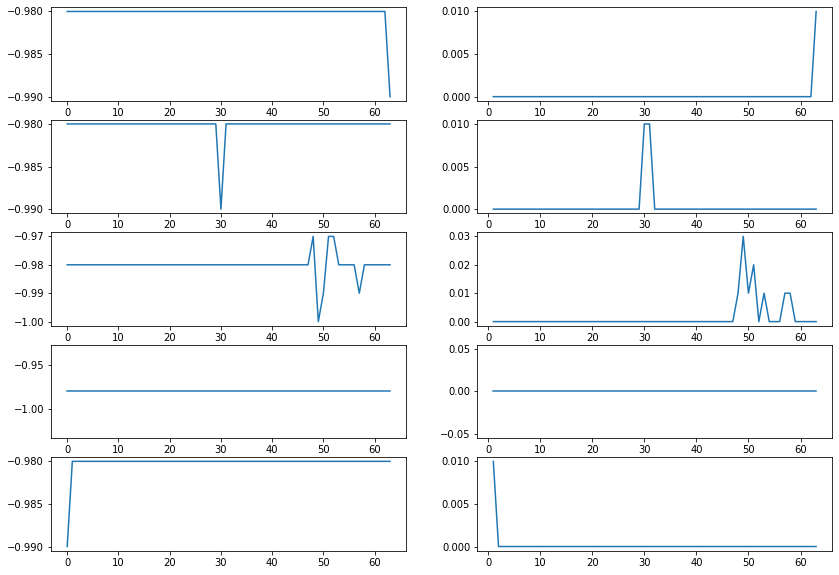

In [8]:
white_windows_data = find_interfloor_noise_data(white_file)
print(white_windows_data.shape)

show_interfloor_noise_data(white_windows_data)

동일하게 추출된 window를 모두 결합한 뒤 원본 데이터와 비교해보자.


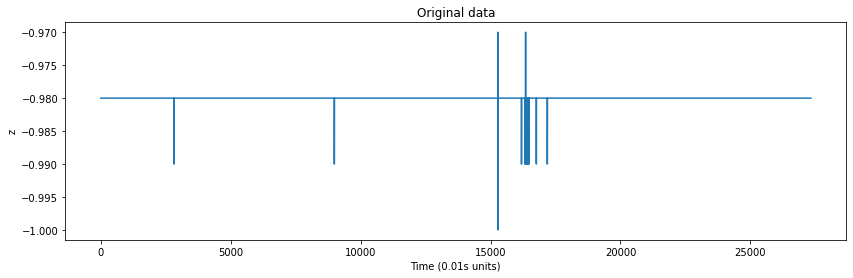

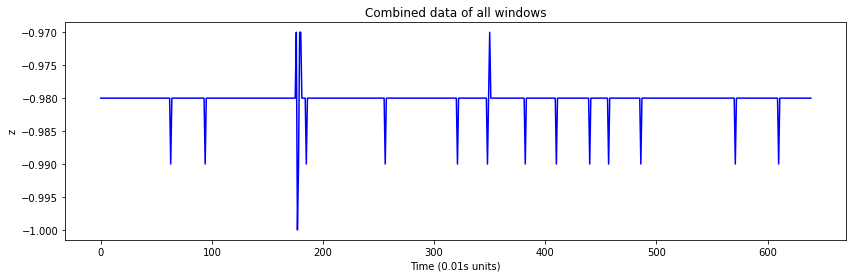

In [9]:
plt.figure(figsize=(14, 4))
plt.plot(pd.read_csv(white_file, header=None, names=[
         'x', 'y', 'z']).loc[:, 'z'], label='z')
plt.title('Original data')
plt.xlabel('Time (0.01s units)')
plt.ylabel('z')
plt.show()

combined_data = white_windows_data.reshape(-1,
                                           white_windows_data.shape[-1])[:, 2]

plt.figure(figsize=(14, 4))
plt.plot(combined_data, label='z', color='b')
plt.title('Combined data of all windows')
plt.xlabel('Time (0.01s units)')
plt.ylabel('z')
plt.show()

전체 데이터 중 9초 가량의 데이터만이 추출됨을 확인할 수 있다.

이를 통해 층간소음이 아닌 데이터는 편차가 크게 발생하지 않으며 층간소음 데이터와 구분이 가능함을 확인할 수 있다.

따라서 위와 같이 편차를 통해 층간소음 유무를 판단하는 방법은 유효하다.
